原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Sequence processing with convnets

# 用卷积神经网络处理序列

This notebook contains the code samples found in Chapter 6, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.


## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

## 实现一维卷积神经网络

Keras 中的一维卷积神经网络是 Conv1D 层，其接口类似于 Conv2D。它接收的输入是形状 为 (samples, time, features) 的三维张量，并返回类似形状的三维张量。卷积窗口是时间轴上的一维窗口（时间轴是输入张量的第二个轴）。

我们来构建一个简单的两层一维卷积神经网络，并将其应用于我们熟悉的 IMDB 情感分类任务。

提醒一下，获取数据并预处理的代码如下所示。


In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  
# Number of words to consider as features（作为特征的单词个数）
max_len = 500  
# cut texts after this number of words (among top max_features most common words)
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)



1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

一维卷积神经网络的架构与第 5 章的二维卷积神经网络相同，它是 Conv1D 层和 MaxPooling1D 层的堆叠，最后是一个全局池化层或 Flatten 层，将三维输出转换为二维输出，让你可以向模型中添加一个或多个 Dense 层，用于分类或回归。

不过二者有一点不同：一维卷积神经网络可以使用更大的卷积窗口。对于二维卷积层，3×3 的卷积窗口包含 3×3=9 个特征向量；但对于一位卷积层，大小为 3 的卷积窗口只包含3个卷积向量。因此，你可以轻松使用大小等于 7 或 9 的一维卷积窗口。 

用于 IMDB 数据集的一维卷积神经网络示例如下所示。


In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (10), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

这里给出了模型的训练结果和验证结果。验证精度略低于 LSTM，但在 CPU 和 GPU 上的运行速度都要更快（速度提高多少取决于具体配置，会有很大差异）。现在，你可以使用正确的轮数（10 轮）重新训练这个模型，然后在测试集上运行。这个结果可以让我们确信，在单词级的情感分类任务上，一维卷积神经网络可以替代循环网络，并且速度更快、计算代价更低。

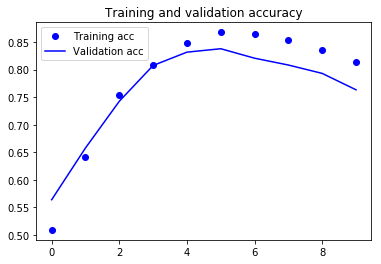

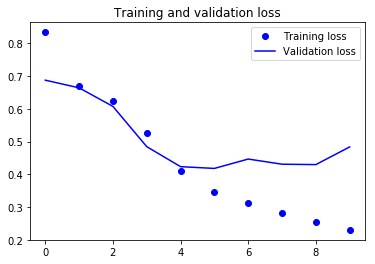

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

## 结合 CNN 和 RNN 来处理长序列

一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感（这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小），这一点与 RNN 不同。当然，为了识别更长期的模式，你可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。想要证明这种方法的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。

看下代码：

In [7]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps
# 我们仍使用上一节定义的变量：float_data, train_gen, val_gen, val_steps

import os
import numpy as np

data_dir = 'data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
# 为了查看整个验证集，需要 从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
# 为了查看整个测试集，需要从 test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 27ms/step - loss: 0.4193 - val_loss: 0.4340
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3624 - val_loss: 0.4420
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3391 - val_loss: 0.4426
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3217 - val_loss: 0.4663
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3078 - val_loss: 0.4545
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3002 - val_loss: 0.4435
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2899 - val_loss: 0.4468
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2850 - val_loss: 0.5008
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2784 - val_loss: 0.4661
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.271

Here are our training and validation Mean Absolute Errors:

下图是我们的训练和验证的均方差（MAE）:

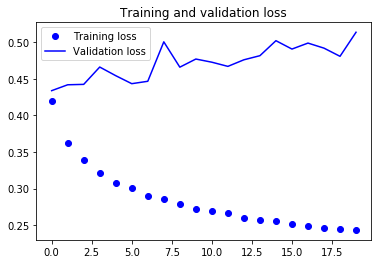

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The validation MAE stays in the low 0.40s-0.50s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because 
our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. 
towards the beginning, towards the end, etc.). Since more recent datapoints should be interpreted differently from older datapoints in the 
case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an 
issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently 
of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing 
step before a RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed 
with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences 
of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

验证 MAE 停留在 0.4~0.5，使用小型卷积神经网络甚至无法击败基于常识的基准方法。同样，这是因为卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置（距开始多长时间，距结束多长时间等）。对于这个具体的预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于 IMDB 数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。

要想结合卷积神经网络的速度和轻量与 RNN 的顺序敏感性，一种方法是在 RNN 前面使用一维卷积神经网络作为预处理步骤（见图 6-30）。对于那些非常长，以至于 RNN 无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中 RNN 的输入。



This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very 
effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to 
manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data 
generator), or look at high-resolution timeseries (by decreasing the `step` parameter of the generator). Here, we will chose (somewhat 
arbitrarily) to use a `step` twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one 
point per 30 minutes.

这种方法在研究论文和实际应用中并不多见，可能是因为很多人并不知道。这种方法非常有效，应该被更多人使用。我们尝试将其应用于温度预测数据集。因为这种方法允许操作更长的序列，所以我们可以查看更早的数据（通过增大数据生成器的 lookback 参数）或查看分辨率更高的时间序列（通过减小生成器的 step 参数）。这里我们任意地将 step 减半，得到时间序列的长度变为之前的两倍，温度数据的采样频率变为每 30 分钟一个数据点。


In [10]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
# 之前设置为 6（每小时一个数据点），现在设置为 3（每 30 分钟一个数据点）

step = 3
lookback = 720  # Unchanged（保持不变）
delay = 144 # Unchanged（保持不变）

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
# 为了查看整个验证集，需要 从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // 128

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
# 为了查看整个测试集，需要从 test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

我们的模型：结合一维卷积基和 GRU 层的模型：

In [11]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 85s 169ms/step - loss: 0.3436 - val_loss: 0.2942
Epoch 2/20
500/500 [===============

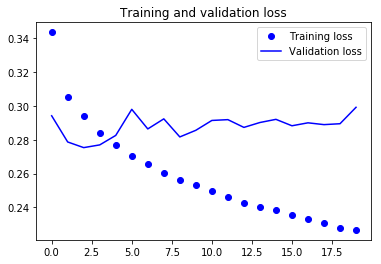

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is 
looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

从验证损失来看，这种架构的效果不如只用正则化 GRU，但速度要快很多。它查看了两倍的数据量，在本例中可能不是非常有用，但对于其他数据集可能非常重要。


## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing 
temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` 
layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D 
convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.

## 小结
下面是你应该从本节中学到的要点。
* 二维卷积神经网络在二维空间中处理视觉模式时表现很好，与此相同，一维卷积神经网络在处理时间模式时表现也很好。对于某些问题，特别是自然语言处理任务，它可以替代 RNN，并且速度更快。
* 通常情况下，一维卷积神经网络的架构与计算机视觉领域的二维卷积神经网络很相似， 它将 Conv1D 层和 MaxPooling1D 层堆叠在一起，最后是一个全局池化运算或展平操作。
* 因为 RNN 在处理非常长的序列时计算代价很大，但一维卷积神经网络的计算代价很小， 所以在 RNN 之前使用一维卷积神经网络作为预处理步骤是一个好主意，这样可以使序列变短，并提取出有用的表示交给 RNN 来处理。
